DSC160 Data Science and the Arts - Twomey - Spring 2020 - [dsc160.roberttwomey.com](http://dsc160.roberttwomey.com)

# Basic Audio Features

This notebook demonstrates how to read, write, and calculate simple time-domain statistics on digital audio. It depends on the [numpy](https://numpy.org/), [matplotlib](https://matplotlib.org/), [seaborn](https://seaborn.pydata.org/), and [LibROSA](https://librosa.github.io/librosa/) libraries. The contents are adapted for DSC160 from the Stanford Music Information Retrieval workshop tutorials on [musicinformationretrieval.com](musicinformationretrieval.com).

__Sections:__ 
- Digital Audio Basics
  - [Setup](#Setup)
  - [Reading Audio Files](#Reading-Audio-Files)
  - [Displaying Waveforms](#Displaying-Waveforms)
- Temporal Features
  - [Zero-Crossings](#Zero-Crossings)
  - [Energy](#Energy)
  - [Autocorrelation and Pitch Estimation](#Autocorrelation-and-Pitch-Estimation)

## Setup

Tell matplotlib to render plots within the jupter frontend.

In [88]:
%matplotlib inline

If you have not previously installed LibROSA, uncomment the following line and run to install.

In [89]:
#!pip install librosa --user

Basic imports

In [90]:
# visualization
import matplotlib.pyplot as plt

# sound processing
import librosa
import librosa.display

# to play audio inline in ipython/jupyter notebooks
from IPython.display import Audio

# numpy
import numpy as np

## Reading Audio Files

Read in a digital audio file, loading it as a waveform (time series of samples) `y` with sample rate `sr`

In [91]:
filename = librosa.util.example_audio_file()
y, sr = librosa.load(filename)

In [92]:
print(type(y), type(sr))

<class 'numpy.ndarray'> <class 'int'>


How many samples do we have, and what is the sample rate?

In [93]:
print(y.shape, sr)

(1355168,) 22050


Given the sample rate and array of samples, how long is our audio file?

In [94]:
length = y.shape[0]/sr
print("file is {:.4} seconds long".format(length))

file is 61.46 seconds long


librosa also has a method for calculating this:

In [95]:
librosa.get_duration(y, sr)

61.45886621315193

What data type are our samples stored in?

In [96]:
print(y.dtype)

float32


What is the range of values in our samples?

In [97]:
print(min(y), max(y))

-0.7105112 0.6505927


NOTE: Typically for a floating point sample, amplitudes (values) will be between normalized between -1.0 and 1.0

### Play an audio file in notebook

It's useful to be able to hear our audio directly in notebook. Here we use the IPython Audio class to create a playable widget inline:

In [98]:
Audio(data=y, rate=sr)

Note: `Audio` can also accept a numpy array. Let's synthesize a pure tone at 440 Hz:

In [99]:
sr = 22050 # sample rate
T = 2.0 # duration in seconds
t = np.linspace(0, T, int(T*sr), endpoint=False) # generate the time stamps for samples
x = 0.5*np.sin(2*np.pi*440*t) # generate the amplitudes (pure sine wave at 440 Hz)

In [100]:
Audio(data=x, rate=sr)

And we can write it to disk (as a [WAV file](https://en.wikipedia.org/wiki/WAV)) using `librosa.output.write_wav`:

In [101]:
librosa.output.write_wav('tone_440.wav', x, sr)

## Displaying Waveforms

Plot the audio file as a waveform. The horizontal axis (X) corresponds to time (minutes:seconds), and vertical axis (Y) corresponds to the instantaneous sound amplitude (pressure)/magnitude of the digital audio signal. 

NOTE: we are using `matplotlib.pyplt` commands and `librosa.display` interchangeably. `librosa.display` builds on matplotlib.

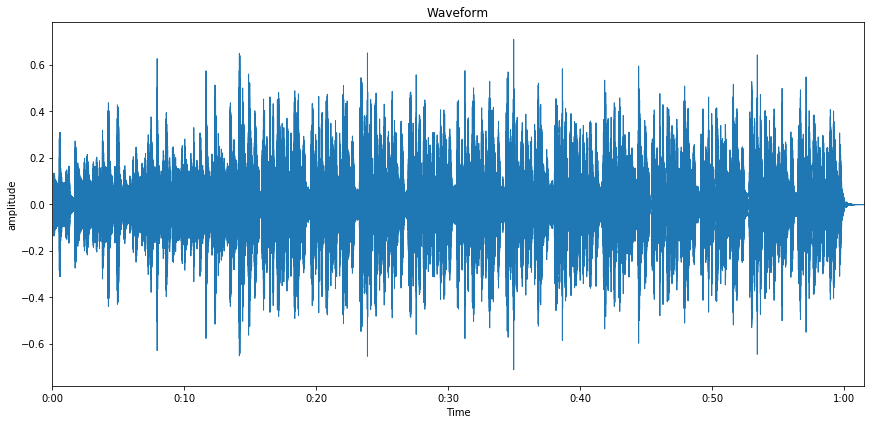

In [102]:
plt.figure(figsize=(12,6))
librosa.display.waveplot(y, sr=sr)
plt.title('Waveform')
plt.tight_layout()
plt.ylabel("amplitude")
plt.show()

If we zoom in on a subrange of the time series (say items 2000-2300 in the array), we can see individual samples and their values:

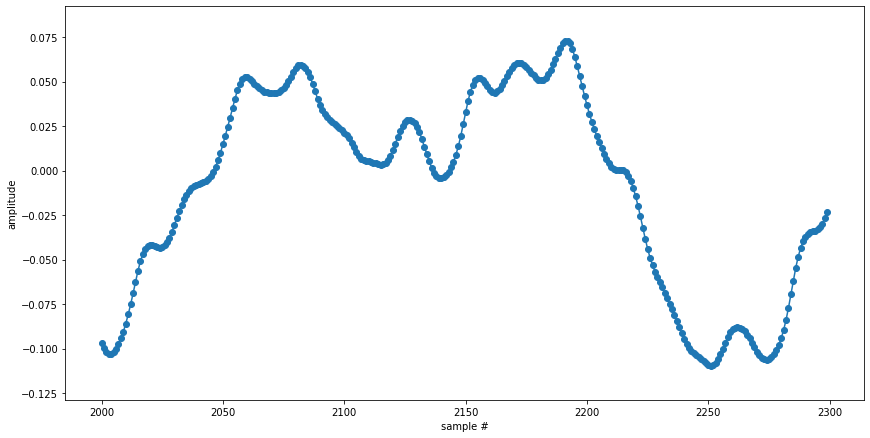

In [103]:
n0 = 2000
n1 = 2300
plt.figure(figsize=(12, 6))
plt.scatter(range(n0, n1), y[n0:n1])
plt.plot(range(n0, n1), y[n0:n1])
plt.tight_layout()
plt.xlabel("sample #")
plt.ylabel("amplitude")
plt.show()

We can convert those sample indices (`n0` and `n1` above) to times (seconds) based on the sample rate for this file:

In [104]:
t0, t1 = librosa.core.samples_to_time((n0, n1), sr)
print("samples from {:0.4f}s - {:0.4}s in the input audio file".format(t0, t1))

samples from 0.0907s - 0.1043s in the input audio file


### Displaying Spectogram

A spectrogram is a visual representation of the spectrum of frequency components of a signal as it changes over time. [wikipedia](https://en.wikipedia.org/wiki/Spectrogram). The plot below uses the [Short-Time Fourier Transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to calculate the magnitudes of frequency components. We'll consider this in following lecture.

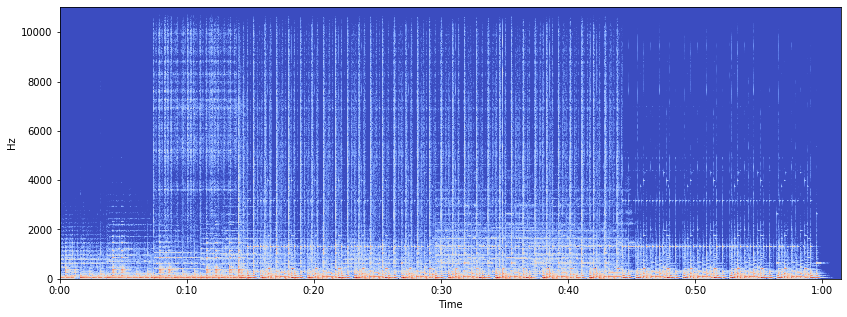

In [105]:
Y = librosa.stft(y)
Ydb = librosa.amplitude_to_db(abs(Y))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='hz')
plt.show()

EXTENSION: repeat the above plots (waveform and spectogram) with the sine tone you generated at the beginning of the notebook.

# Temporal Features of Audio Files

The following sections demonstrate the calculation of basic temporal domain features on our input files.

## Zero-Crossings

The [zero-crossing rate](https://en.wikipedia.org/wiki/Zero-crossing_rate) indicates the number of times that an audio signal crosses the horizontal axis (switches from positive to negative, or negative to positive). This feature is used in speech recognition and music information retrieval, and is a key feature of percussive sounds (drums). For a simple monophonic, tonal signals, the zcr can serve as a rudimentary pitch estimation.

First we will load an audio file:

In [145]:
x, sr = librosa.load('audio/simple_loop.wav')

We can listen to it:

In [146]:
Audio(x, rate=sr)

What does the waveform look like?

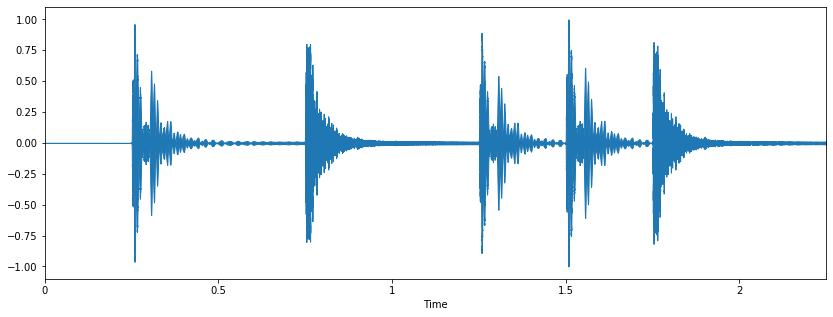

In [147]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
plt.show()

If we zoom in on a small subset of samples, we see a few distinct zero crossings:

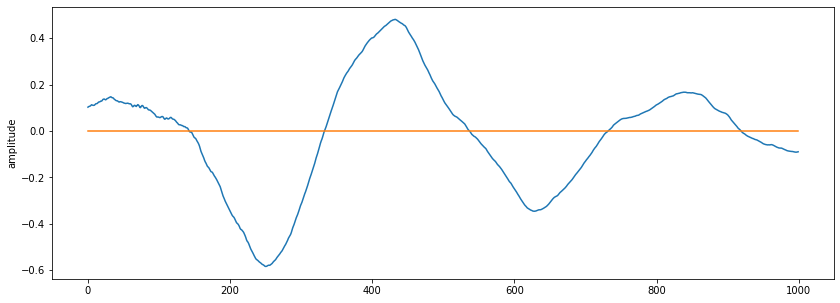

In [151]:
n0 = 6500
n1 = 7500
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.plot([0.0]*(n1-n0))
plt.ylabel("amplitude")
plt.show()

By visual inspection, there appear to be 5 zero crossings. What does librosa compute? 

In [110]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)

Interestingly, the result has as many values as our input sample

In [111]:
zero_crossings.shape

(1000,)

That computed a binary mask where `True` indicates the presence of a zero crossing. To find the total number of zero crossings, use `sum`:

In [112]:
print(sum(zero_crossings))

5


To find the zero-crossing rate over time, we can use librosa's `zero_crossing_rate` method:

In [113]:
zcrs = librosa.feature.zero_crossing_rate(x)
print(zcrs.shape)

(1, 97)


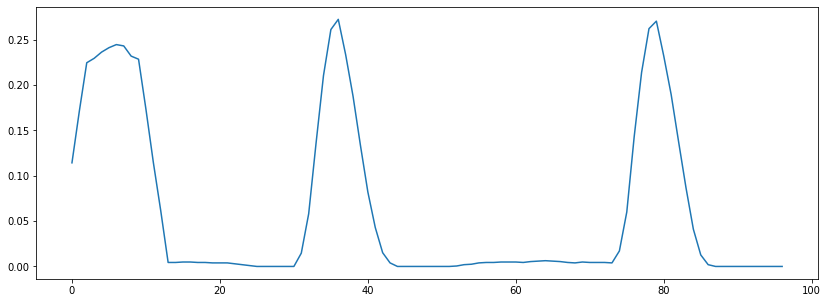

In [114]:
plt.figure(figsize=(14, 5))
plt.plot(zcrs[0])
plt.show()

The reason for the high rate near the beginning is because the silence oscillates quietly around zero:

(-0.0001, 0.0001)

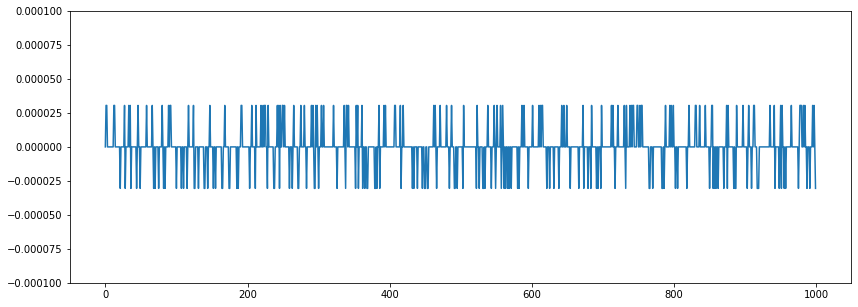

In [115]:
plt.figure(figsize=(14, 5))
plt.plot(x[:1000])
plt.ylim(-0.0001, 0.0001)

A simple hack around this is to add a small constant before computing the zero crossing rate:

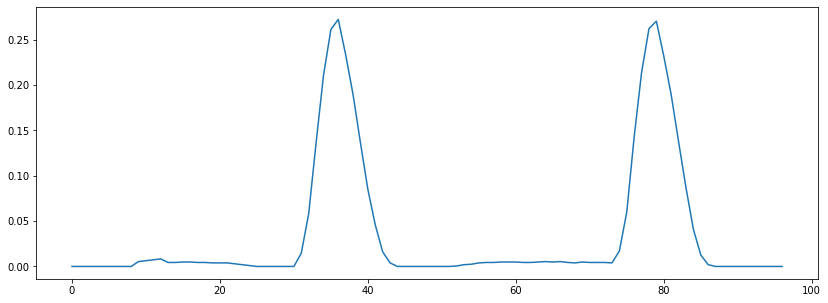

In [116]:
zcrs = librosa.feature.zero_crossing_rate(x + 0.0001)
plt.figure(figsize=(14, 5))
plt.plot(zcrs[0])
plt.show()

EXTENSION: try this calculation of zero-crossing rate with an audio file of your choosing. Does the zero-crossing rate capture valuable information for other kinds of sounds? What about an excerpt from a complex song?

## Energy

The [energy](https://en.wikipedia.org/wiki/Energy_(signal_processing)) of a signal corresponds to the total magntiude of the signal. For audio signals, that roughly corresponds to how loud the signal is. The energy in a signal is defined as

$$ \sum_n \left| x(n) \right|^2 $$

The **root-mean-square (RMS) energy** in a signal is defined as

$$ \sqrt{ \frac{1}{N} \sum_n \left| x(n) \right|^2 } $$


Working with the `simple_loop.wav` from above, lets estimate the amount of energy in the signal at various points in time.

In [117]:
x, sr = librosa.load('audio/simple_loop.wav')

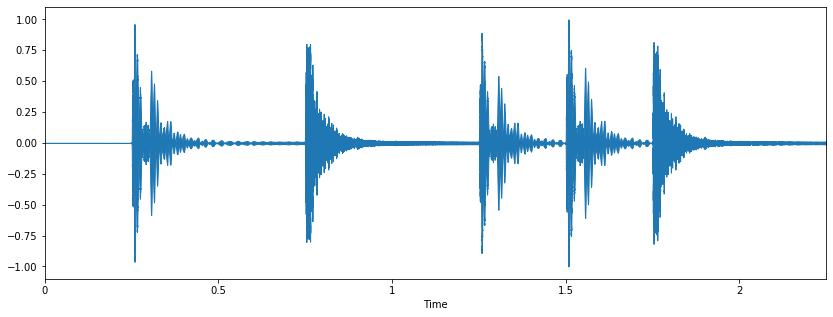

In [118]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
plt.show()

First we will compute the short-time energy using list comprehension. 

"Hop length" below tells us how far over to "hop" for each successive frame of analysis (step size). "Frame length" tells us how wide the window is over which we wish to calculate the energy.

In [119]:
hop_length = 256
frame_length = 512

In [120]:
energy = np.array([
    sum(abs(x[i:i+frame_length])**2)
    for i in range(0, len(x), hop_length)
])

energy.shape

(194,)

Secondly, we compute the root-mean-square (RMS) energy using [`librosa.feature.rms`](https://librosa.github.io/librosa/generated/librosa.feature.rms.html):

In [121]:
rmse = librosa.feature.rms(x, frame_length=frame_length, hop_length=hop_length, center=True)

In [122]:
rmse.shape

(1, 194)

In [123]:
rmse = rmse[0]

Plot both the energy and RMSE along with the waveform:

In [124]:
frames = range(len(energy))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

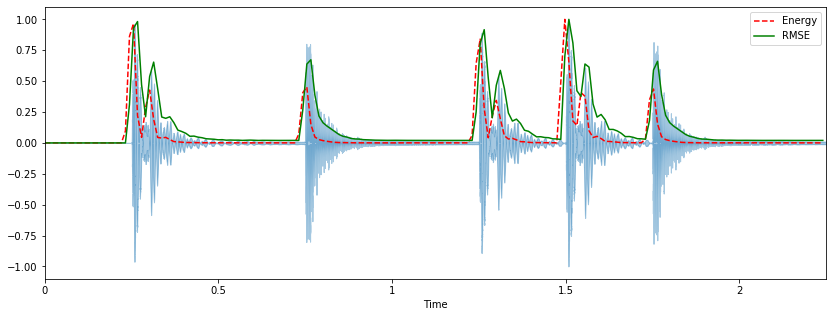

In [125]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, energy/energy.max(), 'r--') # normalized for visualization
plt.plot(t[:len(rmse)], rmse/rmse.max(), color='g') # normalized for visualization
plt.legend(('Energy', 'RMSE'))
plt.show()

NOTE: The Energy plot and RMSE are slightly out of sync, temporally. This is due to the use of `center=True` in `librosa.feature.rms`, which centers the RMSE values calculated over the feature window in the output.

## Autocorrelation and Pitch Estimation

The [autocorrelation](http://en.wikipedia.org/wiki/Autocorrelation) of a signal describes the similarity of a signal against a time-shifted version of itself. For a signal $x$, the autocorrelation $r$ is:

$$ r(k) = \sum_n x(n) x(n-k) $$

In this equation, $k$ is often called the **lag** parameter. $r(k)$ is maximized at $k = 0$ and is symmetric about $k$.

The autocorrelation is useful for finding repeated patterns in a signal. For example, at short lags, the autocorrelation can tell us something about the signal's fundamental frequency. For longer lags, the autocorrelation may tell us something about the tempo of a musical signal. 

This section will walk you through estimating pitch using autocorrelation.

First let's load a file:

In [126]:
x, sr = librosa.load('audio/c_strum.wav')
Audio(x, rate=sr)

...and view its waveform

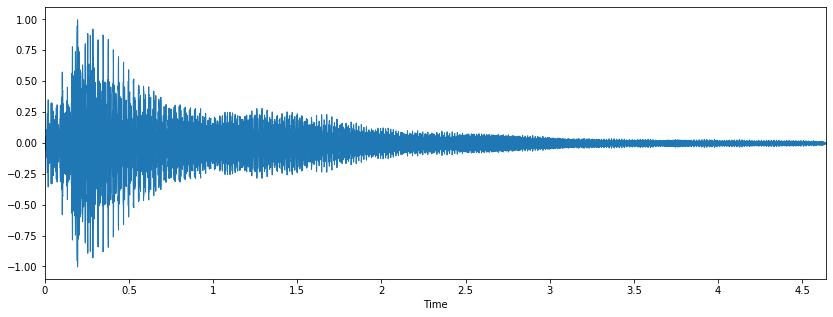

In [127]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr)
plt.show()

There are two ways we can compute the autocorrelation in Python. The first method is [`numpy.correlate`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html). Because the autocorrelation produces a symmetric signal, we only care about the "right half" (so we grab from `len(x)-1` to the end)


In [128]:
r = np.correlate(x, x, mode='full')[len(x)-1:]
print(x.shape, r.shape)

(102400,) (102400,)


Plot the autocorrelation as calculated with numpy:

(0, 10000)

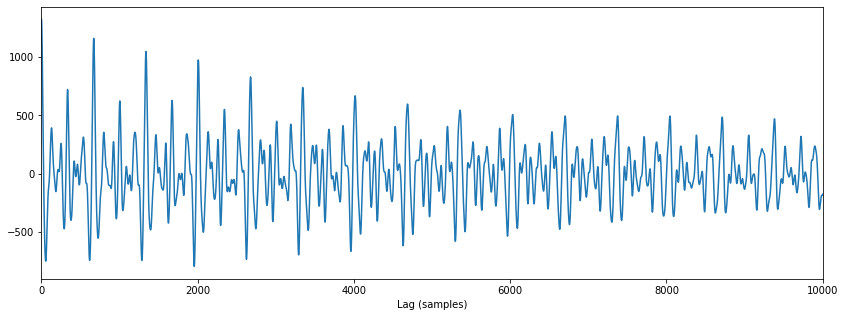

In [129]:
plt.figure(figsize=(14, 5))
plt.plot(r[:10000])
plt.xlabel('Lag (samples)')
plt.xlim(0, 10000)

The second method uses [`librosa.autocorrelate`](https://librosa.github.io/librosa/generated/librosa.core.autocorrelate.html):

In [130]:
r = librosa.autocorrelate(x, max_size=10000)
print(r.shape)

(10000,)


(0, 10000)

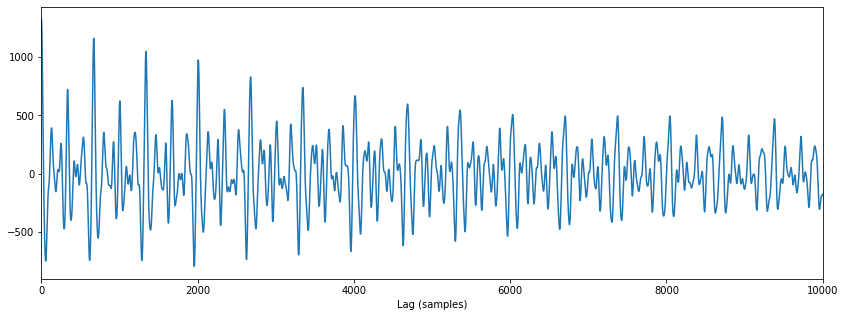

In [131]:
plt.figure(figsize=(14, 5))
plt.plot(r)
plt.xlabel('Lag (samples)')
plt.xlim(0, 10000)

These look pretty similar. The second method, `librosa.autocorrelate` conveniently only keeps one half of the autocorrelation function, since the autocorrelation is symmetric. Also, the `max_size` parameter prevents unnecessary calculations.

### Pitch Estimation with Autocorrelation

The autocorrelation is used to find repeated patterns within a signal. For musical signals, a repeated pattern can correspond to a pitch period. We can therefore use the autocorrelation function to estimate the pitch in a musical signal.

Here is a recording of an oboe playing a single note (C6).

In [132]:
x, sr = librosa.load('audio/oboe_c6.wav')
Audio(x, rate=sr)

Compute and plot the autocorrelation:

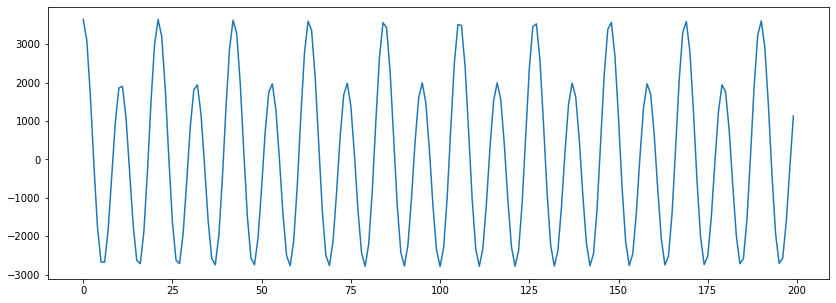

In [133]:
r = librosa.autocorrelate(x, max_size=5000)
plt.figure(figsize=(14, 5))
plt.plot(r[:200])
plt.show()

The autocorrelation always has a maximum at zero, i.e. at zero lag. We want to identify the maximum outside of the peak centered at zero. Therefore, we might choose only to search within a range of reasonable pitches:

In [134]:
# pick low and high bounds based on a reasonable range of notes
# 120 is past the highest key on a piano, 12 is below the lowest
midi_hi = 120.0 
midi_lo = 12.0

# convert midi pitches to frequency (hz)
f_hi = librosa.midi_to_hz(midi_hi)
f_lo = librosa.midi_to_hz(midi_lo)

# calculate the corresponding period (seconds) of each bounding frequency
t_lo = sr/f_hi
t_hi = sr/f_lo

In [135]:
print(f_lo, f_hi)
print(t_lo, t_hi)

16.351597831287414 8372.018089619156
2.633773573344376 1348.4920695523206


Set invalid pitch candidates to zero (zero all values in the autocorrelation result below `t_lo` or above `t_hi`):

In [136]:
r[:int(t_lo)] = 0
r[int(t_hi):] = 0

plot what remains

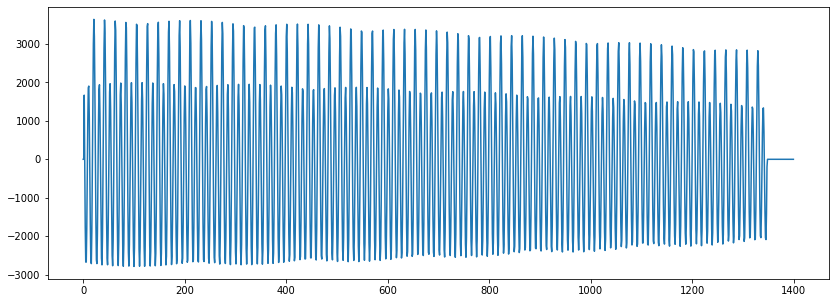

In [137]:
plt.figure(figsize=(14, 5))
plt.plot(r[:1400])
plt.show()

Find the location of the maximum:

In [138]:
t_max = r.argmax()
print(t_max)

21


Finally, estimate the pitch in Hertz:

In [139]:
float(sr)/t_max

1050.0

Indeed, that is very close to the true frequency of C6 (the note that was played by the oboe):

In [140]:
librosa.midi_to_hz(84)

1046.5022612023945

EXTENSION: Repeat the above pitch estimation through autocorrelation using some other tonal (pure tone) audio recording of your choice, for instance a recording of someone singing a certain note. Can you correctly estimate the pitch?

## References
- International Society for Music Information Retrieval (ISMIR) [https://ismir.net/](https://ismir.net/)
- Laboratory for the Recognition and Organization of Speech and Audio at Columbia University: [LabROSA](https://labrosa.ee.columbia.edu/)
  - LibROSA [https://librosa.github.io/librosa/](https://librosa.github.io/librosa/)
- Brian McFee - SciPy 2015 Talk on Audio Processing and Music Information Retrieval (MIR) with LibROSA: https://www.youtube.com/watch?v=MhOdbtPhbLU
  - [website](https://bmcfee.github.io/) [paper](https://bmcfee.github.io/papers/scipy2015_librosa.pdf)
- Code examples above are adapted from [musicinformationretrieval.com](https://musicinformationretrieval.com/), including:
  - [Zero-Crossing Rate](https://musicinformationretrieval.com/zcr.html)
  - [Energy](https://musicinformationretrieval.com/energy.html)
  - [Autocorrelation](https://musicinformationretrieval.com/autocorrelation.html)
